In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/home-data-for-ml-course/train.csv.gz
/kaggle/input/home-data-for-ml-course/test.csv
/kaggle/input/home-data-for-ml-course/sample_submission.csv
/kaggle/input/home-data-for-ml-course/test.csv.gz
/kaggle/input/home-data-for-ml-course/sample_submission.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv
/kaggle/input/home-data-for-ml-course/data_description.txt


Importing all libraries in one cell

In [2]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from sklearn.linear_model import LassoCV
from sklearn import metrics 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, cross_val_score
from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

from mlxtend.regressor import StackingCVRegressor


import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy.stats import skew

Reading data

In [3]:
home = pd.read_csv('../input/home-data-for-ml-course/train.csv', index_col='Id')
test = pd.read_csv('../input/home-data-for-ml-course/test.csv', index_col='Id')

Remove rows with missing target, separate target from predictors

In [4]:
home.dropna(axis=0, subset=['SalePrice'], inplace=True)

Understanding data

In [5]:
print(home.shape)
print(test.shape)

(1460, 80)
(1459, 79)


Removing columns with lots of missing values

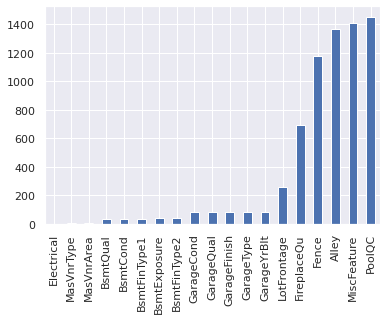

In [6]:
missing = home.isnull().sum()
missing = missing[missing>0]
missing.sort_values(inplace=True)
missing.plot.bar()

All categorical columns are low cardinality columns

**Univariate analysis**

**Bivariate analysis**

Using these analysis we find the columns with clear outliers
* LotFrontage
* LotArea
* MasVnrArea
* BsmtFinSF1
* TotalBsmtSF
* GrLivArea
* 1stFlrSF
* EnclosedPorch
* MiscVal
* LowQualFinSF

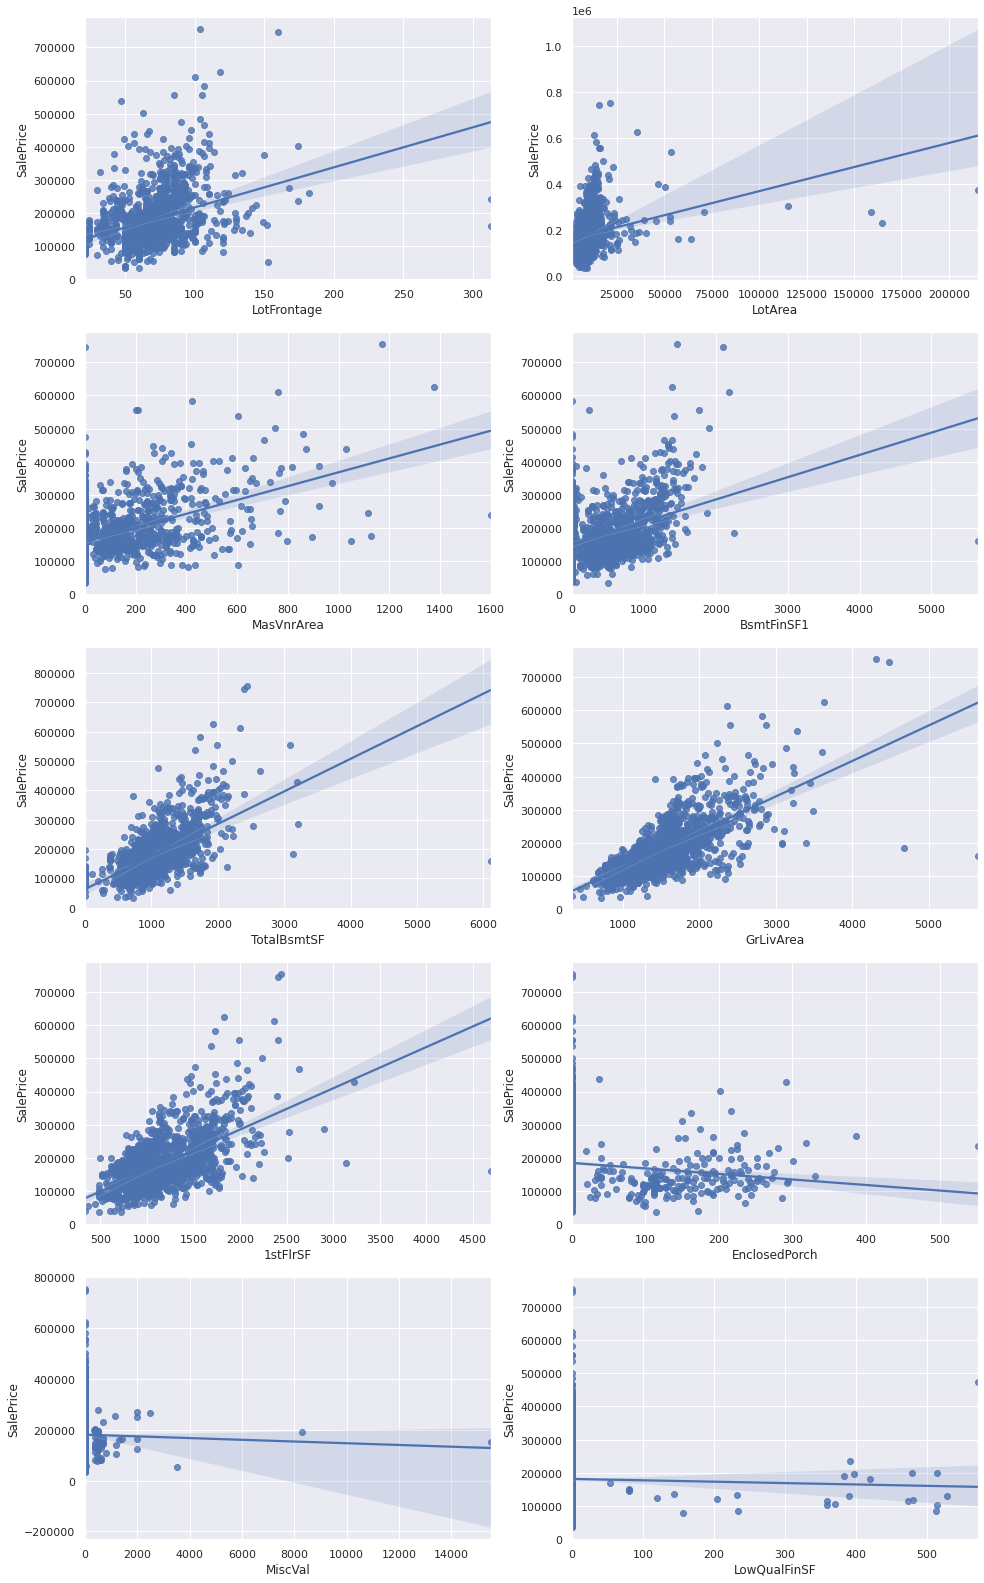

In [7]:
figure, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10)) = plt.subplots(nrows=5, ncols=2)
figure.set_size_inches(16,28)
_ = sns.regplot(home['LotFrontage'], home['SalePrice'], ax=ax1)
_ = sns.regplot(home['LotArea'], home['SalePrice'], ax=ax2)
_ = sns.regplot(home['MasVnrArea'], home['SalePrice'], ax=ax3)
_ = sns.regplot(home['BsmtFinSF1'], home['SalePrice'], ax=ax4)
_ = sns.regplot(home['TotalBsmtSF'], home['SalePrice'], ax=ax5)
_ = sns.regplot(home['GrLivArea'], home['SalePrice'], ax=ax6)
_ = sns.regplot(home['1stFlrSF'], home['SalePrice'], ax=ax7)
_ = sns.regplot(home['EnclosedPorch'], home['SalePrice'], ax=ax8)
_ = sns.regplot(home['MiscVal'], home['SalePrice'], ax=ax9)
_ = sns.regplot(home['LowQualFinSF'], home['SalePrice'], ax=ax10)

In [8]:
home = home.drop(home[home['LotFrontage']>200].index)
home = home.drop(home[home['LotArea']>100000].index)
home = home.drop(home[home['MasVnrArea']>1200].index)
home = home.drop(home[home['BsmtFinSF1']>4000].index)
home = home.drop(home[home['TotalBsmtSF']>4000].index)
home = home.drop(home[(home['GrLivArea']>4000) & (home['SalePrice']<300000)].index)
home = home.drop(home[home['1stFlrSF']>4000].index)
home = home.drop(home[home['EnclosedPorch']>500].index)
home = home.drop(home[home['MiscVal']>5000].index)
home = home.drop(home[(home['LowQualFinSF']>600) & (home['SalePrice']>400000)].index)

In [9]:
home.shape

(1448, 80)

In [10]:
home.drop(columns=['GarageArea','TotRmsAbvGrd','GarageYrBlt','1stFlrSF'],axis=1,inplace=True) 
test.drop(columns=['GarageArea','TotRmsAbvGrd','GarageYrBlt','1stFlrSF'],axis=1,inplace=True)

In [11]:
# Useless Columns...
home=home.drop(columns=['Street','Utilities']) 
test=test.drop(columns=['Street','Utilities']) 

In [12]:
home.drop(columns=['Alley','MiscFeature','PoolQC','PoolArea'], axis=1, inplace=True)
test.drop(columns=['Alley','MiscFeature','PoolQC','PoolArea'], axis=1, inplace=True)

Dealing with lot frontage

In [13]:
home['LotFrontage'] = home.groupby('Neighborhood')['LotFrontage'].apply(lambda x: x.fillna(x.median()))
test['LotFrontage'] = test.groupby('Neighborhood')['LotFrontage'].apply(lambda x: x.fillna(x.median()))

In [14]:
numerical_features = [cname for cname in home.columns if home[cname].dtype in ['int64', 'float64']]
categorical_features = [cname for cname in test.columns if test[cname].nunique() < 10 and 
                        test[cname].dtype == "object"]
numerical_features.remove('SalePrice')
len(numerical_features)
print(numerical_features)

['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces', 'GarageCars', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'MiscVal', 'MoSold', 'YrSold']


In [15]:
my_imputer= SimpleImputer()
for col in ('GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 
                'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotalBsmtSF',
                'Fireplaces', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'MiscVal',
                'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea'):
    home[col] = my_imputer.fit_transform(home[col].values.reshape(-1,1))
    test[col] = my_imputer.transform(test[col].values.reshape(-1,1))

In [16]:
for df in [home, test]:
    for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                  'BsmtFinType2', 'Neighborhood', 'BldgType', 'HouseStyle', 'MasVnrType', 'FireplaceQu', 'Fence'):
        df[col] = df[col].fillna('None')

for df in [home, test]:
    for col in ('LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Condition1', 'RoofStyle',
                  'Electrical', 'Functional', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'ExterQual', 'ExterCond',
                  'Foundation', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'PavedDrive', 'SaleType', 'SaleCondition'):
        df[col] = df[col].fillna(df[col].mode()[0])

In [17]:
home['MSSubClass'] = home['MSSubClass'].apply(str)
test['MSSubClass'] = test['MSSubClass'].apply(str)

home['MoSold'] = home['MoSold'].apply(str)
test['MoSold'] = test['MoSold'].apply(str)

home['YrSold'] = home['MoSold'].apply(str)
test['YrSold'] = test['MoSold'].apply(str)

home['MSZoning'] = home.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
test['MSZoning'] = test.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

In [18]:
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(home[categorical_features]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(test[categorical_features]))

# One-hot encoding removed index; put it back
OH_cols_train.index = home.index
OH_cols_valid.index = test.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = home.drop(categorical_features, axis=1)
num_X_valid = test.drop(categorical_features, axis=1)

# Add one-hot encoded columns to numerical features
home_final = pd.concat([num_X_train, OH_cols_train], axis=1)
test_final = pd.concat([num_X_valid, OH_cols_valid], axis=1)

Feature Engineering

In [19]:
home['TotalSF']=home['TotalBsmtSF']  + home['2ndFlrSF']
test['TotalSF']=test['TotalBsmtSF']  + test['2ndFlrSF']
home['TotalBath']=home['BsmtFullBath'] + home['FullBath'] + (0.5*home['BsmtHalfBath']) + (0.5*home['HalfBath'])
test['TotalBath']=test['BsmtFullBath'] + test['FullBath'] + test['BsmtHalfBath'] + test['HalfBath']
home['YrBltAndRemod']=home['YearBuilt']+(home['YearRemodAdd']/2)
test['YrBltAndRemod']=test['YearBuilt']+(test['YearRemodAdd']/2)
home['Porch_SF'] = (home['OpenPorchSF'] + home['3SsnPorch'] + home['EnclosedPorch'] + home['ScreenPorch'] + home['WoodDeckSF'])
test['Porch_SF'] = (test['OpenPorchSF'] + test['3SsnPorch'] + test['EnclosedPorch'] + test['ScreenPorch'] + test['WoodDeckSF'])

home['Has2ndfloor'] = home['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
home['HasBsmt'] = home['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
home['HasFirePlace'] = home['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
home['Has2ndFlr']=home['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
home['HasBsmt']=home['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)

test['Has2ndfloor'] = test['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
test['HasBsmt'] = test['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
test['HasFirePlace'] = test['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
test['Has2ndFlr']=test['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
test['HasBsmt']=test['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)

home['LotArea'] = home['LotArea'].astype(np.int64)
test['LotArea'] = test['LotArea'].astype(np.int64)
home['MasVnrArea'] = home['MasVnrArea'].astype(np.int64)
test['MasVnrArea'] = test['MasVnrArea'].astype(np.int64)

In [20]:
X = home.drop(['SalePrice'], axis=1)
y = np.log1p(home['SalePrice'])

In [21]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=2)

In [22]:
categorical_cols = [cname for cname in X.columns if
                    X[cname].nunique() <= 30 and
                    X[cname].dtype == "object"] 
                


numerical_cols = [cname for cname in X.columns if
                 X[cname].dtype in ['int64','float64']]


my_cols = numerical_cols + categorical_cols

X_train = X_train[my_cols].copy()
X_valid = X_valid[my_cols].copy()
X_test = test[my_cols].copy()

In [23]:
num_transformer = Pipeline(steps=[
    ('num_imputer', SimpleImputer())
    ])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numerical_cols),       
        ('cat',cat_transformer,categorical_cols),
        ])

In [24]:
def inv_y(transformed_y):
    return np.exp(transformed_y)


model = XGBRegressor(learning_rate=0.01, n_estimators=8000,early_stopping_rounds=10,max_depth=3, min_child_weight=0,gamma=0, subsample=0.6,colsample_bytree=0.5,objective='reg:squarederror', nthread=-1,scale_pos_weight=1, seed=27, reg_alpha=0.00006)
clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('model', model)])
clf.fit(X_train, y_train)
predict = clf.predict(X_valid)
print('XGBoost: ' + str(mean_absolute_error(inv_y(predict), inv_y(y_valid))))

[13:49:47] WARNING: /workspace/src/learner.cc:480: 
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


XGBoost: 13820.155387931038


In [25]:
model = XGBRegressor(learning_rate=0.01, n_estimators=8000,early_stopping_rounds=10,
                     max_depth=3, min_child_weight=0,
                     gamma=0, subsample=0.6,
                     colsample_bytree=0.5,
                     objective='reg:squarederror', nthread=-1,
                     scale_pos_weight=1, seed=27,
                     reg_alpha=0.00006)

final_model = Pipeline(steps=[('preprocessor', preprocessor),
                          ('model', model)])

final_model.fit(X_train, y_train)

final_predictions = final_model.predict(X_test)

[13:50:05] WARNING: /workspace/src/learner.cc:480: 
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [26]:
output = pd.DataFrame({'Id': X_test.index,
                       'SalePrice': inv_y(final_predictions)})

output.to_csv('submission.csv', index=False)